# CM50268 Coursework 2C — Bayesian Machine Learning Mini‐Project

In order to meet the client's request, this notebook uses Bayesian hierarchical modeling and NumPyro for Hamiltonian Monte Carlo inference. We use both the normal exponential decay model and an enhanced model with component diagnostics.

## Necessary Imports

In [1]:
# imports
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro import render_model
import jax.numpy as jnp
from jax import random
import arviz as az
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set the number of chains to use multiple CPU cores
numpyro.set_host_device_count(4)

## Loading the Data + EDA

In [3]:
# load the data
df = pd.read_csv("component-data-2c.csv")

In [4]:
# display the first 5 rows of the data
df.head()

,ID,index,X1,X2,X3,X4,X5,day,integrity
0,K#0000,0,1.897,1.111,0.585,1.436,3.684,1.0,94.203
1,K#0000,0,1.897,1.111,0.585,1.436,3.684,3.0,90.663
2,K#0000,0,1.897,1.111,0.585,1.436,3.684,5.0,76.650
3,K#0000,0,1.897,1.111,0.585,1.436,3.684,7.0,74.893
4,K#0000,0,1.897,1.111,0.585,1.436,3.684,8.0,73.923


In [5]:
# check for missing values
df.isnull().sum().sum()

np.int64(0)

In [6]:
# find the unique x1, x2, x3, x4, and x5 values for each component
features = df[['index', 'X1', 'X2', 'X3', 'X4', 'X5']].drop_duplicates().set_index('index')

# find the time series integrity values
measurements = df[['index', 'day', 'integrity']]

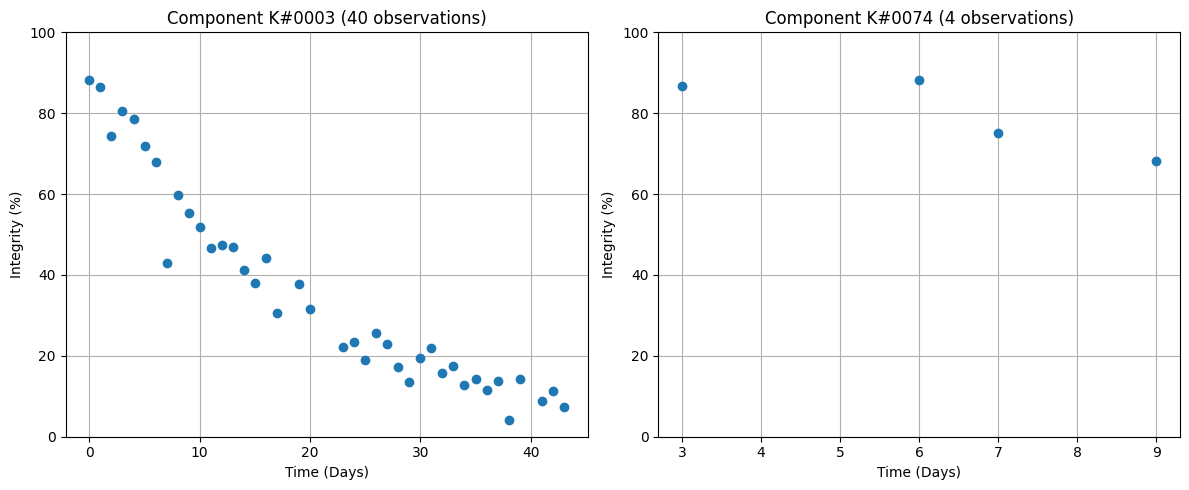

In [ ]:
# lets see how the data looks for different components

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# plot for K#0003
subset = measurements[measurements['index'] == 3]
axes[0].plot(subset['day'], subset['integrity'], 'o')
axes[0].set_title(f"Component K#0003 (40 observations)")
axes[0].set_xlabel("Time (Days)")
axes[0].set_ylabel("Integrity (%)")
axes[0].set_ylim(0, 100)
axes[0].grid(True)

# plot for K#0074
subset = measurements[measurements['index'] == 74]
axes[1].plot(subset['day'], subset['integrity'], 'o')
axes[1].set_title(f"Component K#0074 (4 observations)")
axes[1].set_xlabel("Time (Days)")
axes[1].set_ylabel("Integrity (%)")
axes[1].set_ylim(0, 100)
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Baseline Model

We begin by implementing the **baseline model** as described in Equation 1 of the specification:

> **yᵢ(t) = fᵢ(t) + ε**, _where_

> **fᵢ(t) = uᵢ · exp(-vᵢ · t / 100)**

Where:
- **uᵢ** is an “intercept” term, the value of fᵢ when t = 0
- **vᵢ** is a “decay rate” term
- **ε** may be considered a measurement noise or error term,and is generally accepted to be approximately Gaussian with some unknown standard deviation **σ𝑦**

Both **uᵢ** and **vᵢ** are assumed to follow hierarchical Gaussian priors.

We implement this using NumPyro, with HMC for posterior inference.

In [8]:
# baseline model function
def baseline_model(id, days, integrity):
    
    # hyperpriors for intercepts (u) and decay rates (v)
    μ_u = numpyro.sample("μ_u", dist.Normal(90, 5))
    σ_u = numpyro.sample("σ_u", dist.HalfNormal(5))
    μ_v = numpyro.sample("μ_v", dist.Normal(5, 2))
    σ_v = numpyro.sample("σ_v", dist.HalfNormal(2))

    # find the number of components
    n_components = len(np.unique(id))

    with numpyro.plate("id_i", n_components):
        # priors for each component-specific u_i and v_i
        u = numpyro.sample("u", dist.Normal(μ_u, σ_u))
        v = numpyro.sample("v", dist.Normal(μ_v, σ_v))
    
    # observation noise standard deviation
    σ_y = numpyro.sample("σ_y", dist.HalfNormal(5))

    # find fi using the forumula f_i(t) = u_i * exp(-v_i * t / 100)
    fi = u[id] * jnp.exp((-v[id] * days)/100)
    numpyro.deterministic("fi", fi)

    # observation likelihood
    with numpyro.plate("data", len(id)):
        numpyro.sample("obs", dist.Normal(fi, σ_y), obs=integrity)

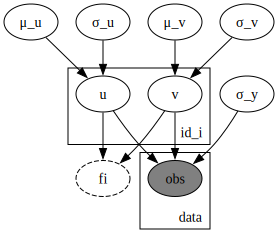

In [9]:
# store the data into variables
id_data = measurements['index'].values
days_data = measurements['day'].values
integrity_data = measurements['integrity'].values

# render the baseline model
render_model(baseline_model, model_args=(id_data, days_data, integrity_data), render_params=True)

In [10]:
# run HMC on the baseline model
nuts_kernel = NUTS(baseline_model)
mcmc_base = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000, num_chains=4)
mcmc_base.run(random.PRNGKey(0), id=id_data, days=days_data, integrity=integrity_data)
mcmc_base.print_summary()

Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/4000 [00:01<?, ?it/s]



Running chain 0:   5%|▌         | 200/4000 [00:05<01:11, 53.17it/s]


Running chain 0:  10%|█         | 400/4000 [00:05<00:31, 113.54it/s]


Running chain 0:  15%|█▌        | 600/4000 [00:05<00:18, 179.61it/s]


Running chain 0:  20%|██        | 800/4000 [00:06<00:12, 246.35it/s]


Running chain 0:  25%|██▌       | 1000/4000 [00:06<00:09, 308.43it/s]


Running chain 0:  30%|███       | 1200/4000 [00:06<00:07, 372.98it/s]


Running chain 0:  35%|███▌      | 1400/4000 [00:07<00:06, 430.05it/s]


Running chain 0:  40%|████      | 1600/4000 [00:07<00:04, 481.49it/s]


Running chain 0:  45%|████▌     | 1800/4000 [00:07<00:04, 523.60it/s]


Running chain 0:  50%|█████     | 2000/4000 [00:08<00:03, 551.19it/s]


Running chain 0:  55%|█████▌    | 2200/4000 [00:08<00:03, 536.96it/s]


Running chain 0:  60%|██████    | 2400/4000 [00:09<00:03, 527.55it/s]


Running chain 0:  65


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      u[0]     93.97      2.27     93.96     90.19     97.69  12349.93      1.00
      u[1]     87.45      4.38     87.49     80.03     94.45  12065.27      1.00
      u[2]     98.49      2.26     98.49     94.65    102.02  11328.17      1.00
      u[3]     89.31      2.11     89.32     86.03     92.96  13767.85      1.00
      u[4]     87.21      3.83     87.29     80.85     93.26  12893.84      1.00
      u[5]     89.41      4.00     89.39     82.81     95.91  11615.08      1.00
      u[6]     91.68      3.71     91.62     85.38     97.54  10732.27      1.00
      u[7]     85.18      4.09     85.25     78.79     92.32  10334.39      1.00
      u[8]     89.96      3.57     89.93     84.11     95.78  12413.94      1.00
      u[9]     86.20      4.12     86.20     79.16     92.64  10625.29      1.00
     u[10]     85.30      2.93     85.30     80.32     90.03  11927.12      1.00
     u[11]     87.89      3

array([[<Axes: title={'center': 'μ_u'}>, <Axes: title={'center': 'μ_u'}>],
       [<Axes: title={'center': 'μ_v'}>, <Axes: title={'center': 'μ_v'}>],
       [<Axes: title={'center': 'σ_u'}>, <Axes: title={'center': 'σ_u'}>],
       [<Axes: title={'center': 'σ_v'}>, <Axes: title={'center': 'σ_v'}>],
       [<Axes: title={'center': 'σ_y'}>, <Axes: title={'center': 'σ_y'}>],
       [<Axes: title={'center': 'u'}>, <Axes: title={'center': 'u'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

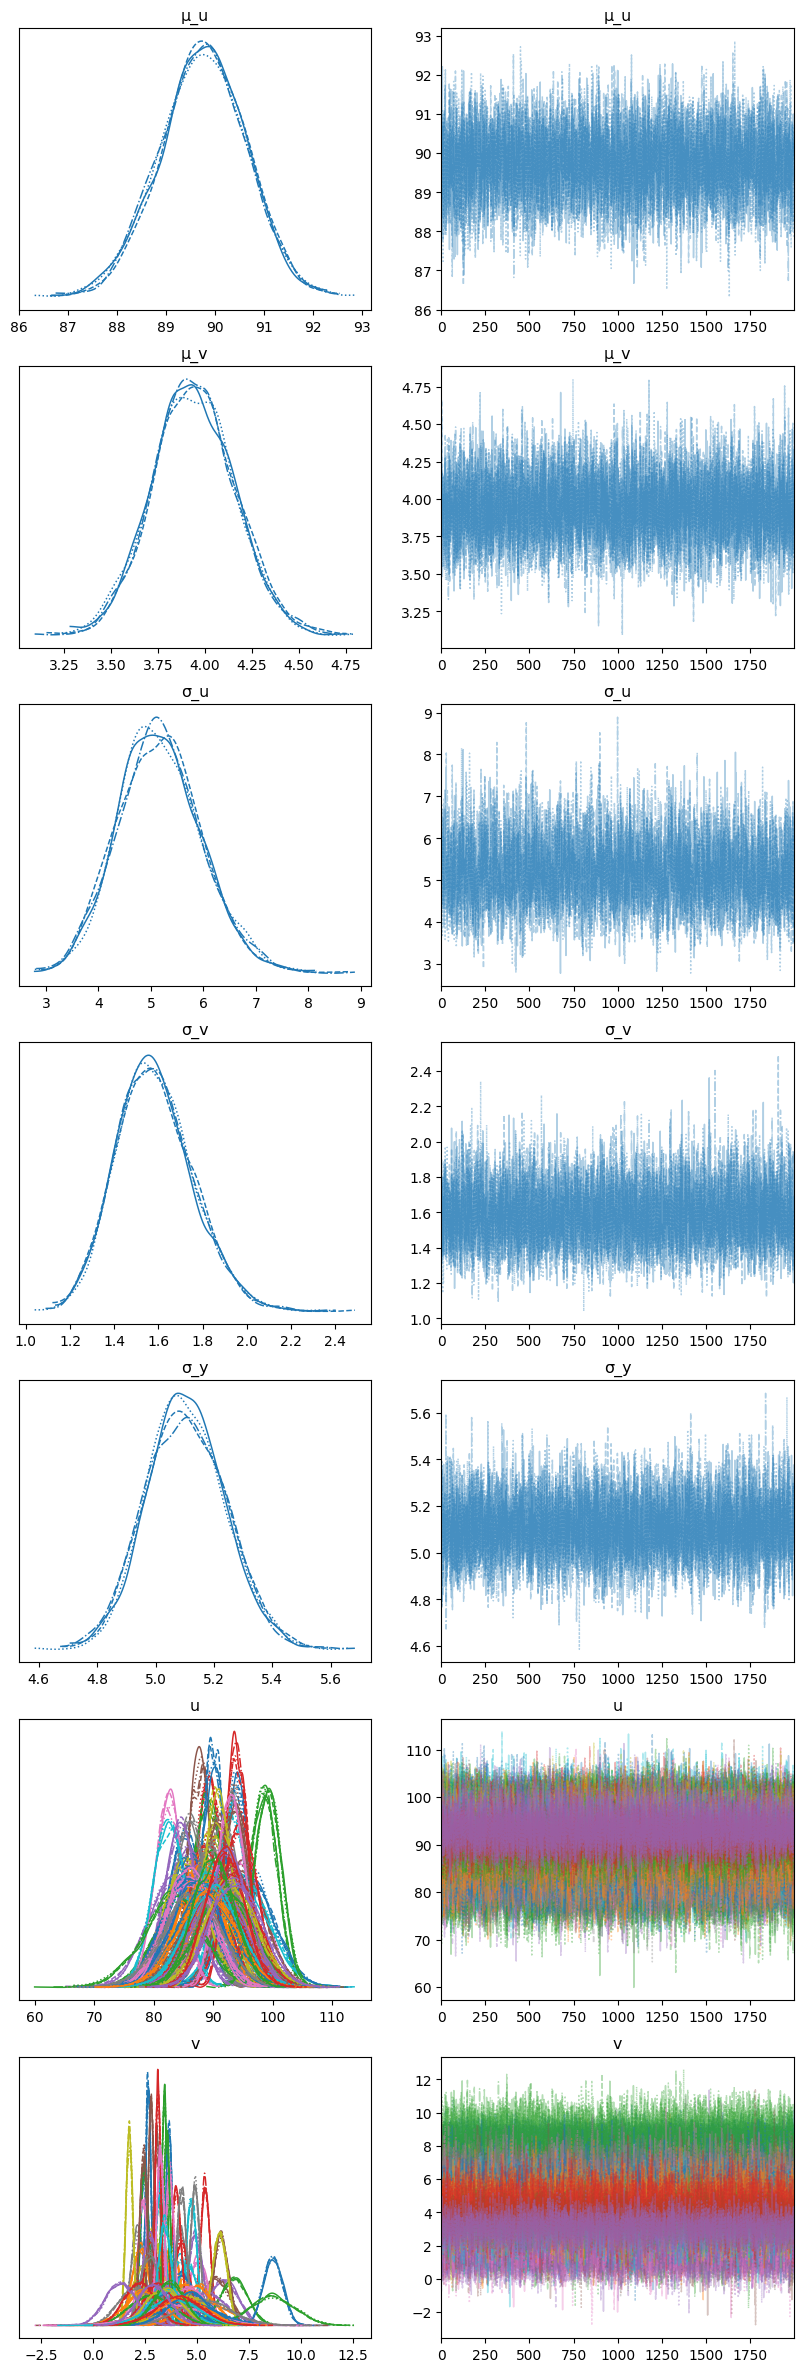

In [11]:
# plotting the results
data = az.from_numpyro(mcmc_base)
az.plot_trace(data, compact=True, var_names=["μ_u", "μ_v", "σ_u", "σ_v", "σ_y", "u", "v"], figsize=(10, 30))

In [12]:
# extract posterior samples
samples_base = mcmc_base.get_samples()

# predictive functions for baseline model
def predict_baseline_overall(id, mcmc_samples, t):
    ui = mcmc_samples['u'][:, id][:, None]
    vi = mcmc_samples['v'][:, id][:, None]
    Y = ui * jnp.exp(-(vi * t) / 100)
    f_mean = jnp.mean(Y, axis=0)
    noise_var = jnp.mean(mcmc_samples['σ_y']) ** 2
    f_var = jnp.var(Y, axis=0) + noise_var
    f_std = jnp.sqrt(f_var)
    return np.asarray(f_mean), np.asarray(f_std)

def predict_baseline_function(id, mcmc_samples, t):
    ui = mcmc_samples['u'][:, id][:, None]
    vi = mcmc_samples['v'][:, id][:, None]
    Y = ui * jnp.exp(-(vi * t) / 100)
    f_mean = jnp.mean(Y, axis=0)
    f_var = jnp.var(Y, axis=0)
    f_std = jnp.sqrt(f_var)
    return np.asarray(f_mean), np.asarray(f_std)

In [13]:
# plot baseline predictions
t_vals = jnp.linspace(0, 60, 100)

def plot_predictions_baseline(component):
    mean_f, std_f = predict_baseline_function(component, samples_base, t_vals)
    mean_o, std_o = predict_baseline_overall(component, samples_base, t_vals)

    actual = measurements[measurements['index'] == component]
    x = actual['day']
    y = actual['integrity']

    _, ax = plt.subplots(figsize=(8, 5))
    ax.set_title(f"Baseline Model Prediction Graph - Component {component}")
    ax.scatter(x, y, label="Observed Data")
    ax.plot(t_vals, mean_f, color="Firebrick", label="Posterior Mean")
    ax.fill_between(t_vals, mean_f - 1.96 * std_f, mean_f + 1.96 * std_f,alpha=0.5, color="Skyblue", label="Function Error Bar")
    ax.fill_between(t_vals, mean_o - 1.96 * std_o, mean_o + 1.96 * std_o, alpha=0.3, color="Goldenrod", label="Function+Noise Error Bar")
    ax.set_xlabel("Day")
    ax.set_ylabel("Integrity (%)")
    ax.set_ylim(0, 100)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

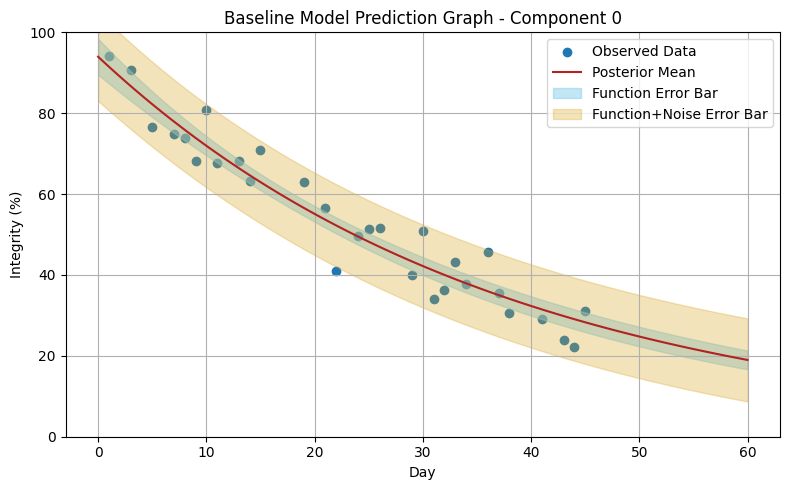

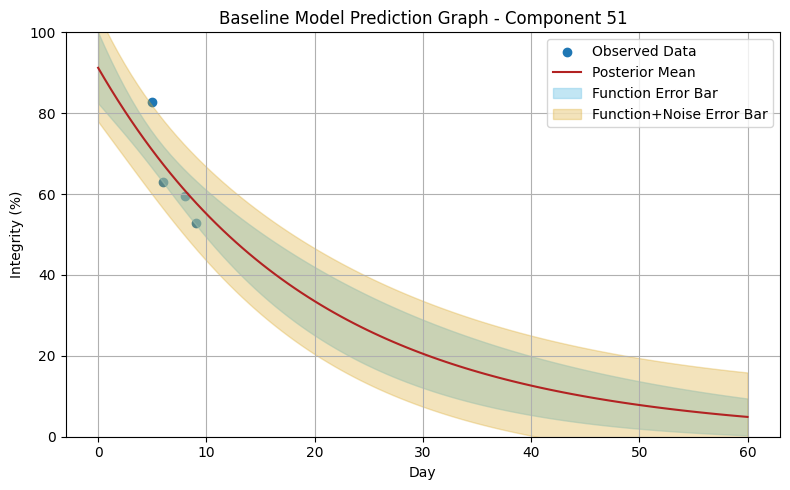

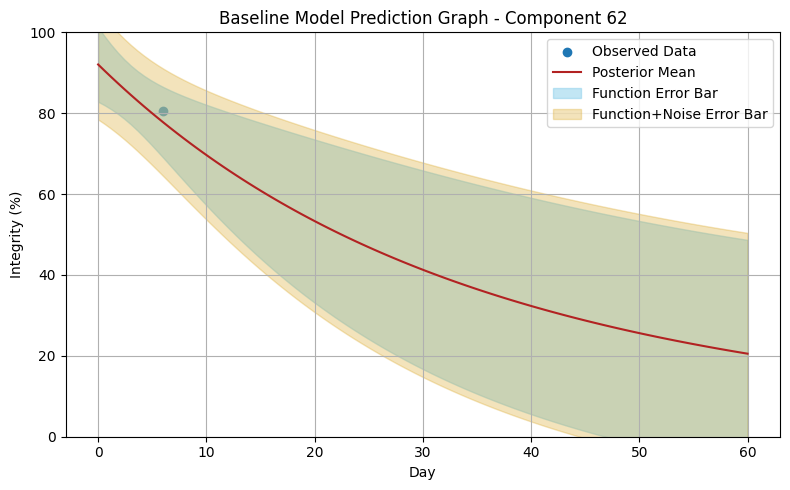

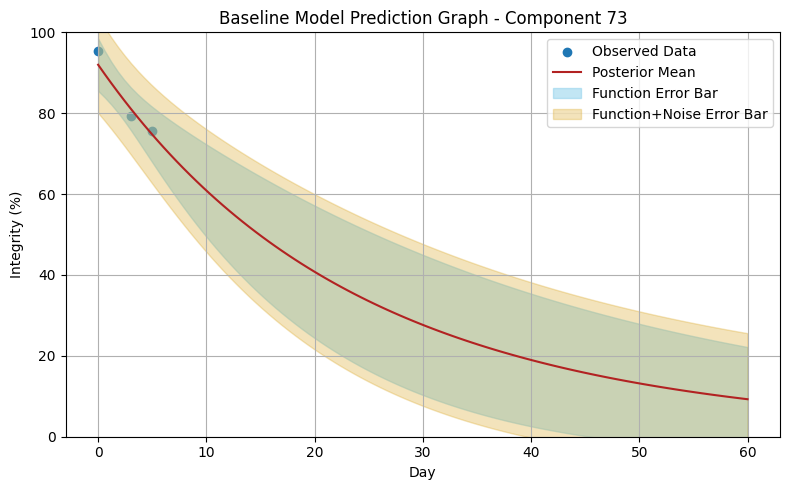

In [14]:
# plot four components (one dense, three sparse)
for component in [0, 51, 62, 73]:
    plot_predictions_baseline(component)

## Enhanced Model

We now add further component-specific features (X1–X5) to the baseline exponential decay model, outlined in Equation (2) of the specification.

These features are used to adjust the decay rate through a shared linear weighting, allowing the model to explain differences in degradation patterns using physical diagnostics. This helps meet client objective 3: understanding potential causes of degradation.

In [15]:
# enhanced model function (from spec equation 2)
def enhanced_model(id, x_data, days, integrity):
    
    # hyperpriors for intercepts (u) and decay rates (v)
    μ_u = numpyro.sample("μ_u", dist.Normal(90, 10)) # broader prior
    σ_u = numpyro.sample("σ_u", dist.HalfNormal(5))
    μ_v = numpyro.sample("μ_v", dist.Normal(5, 2))
    σ_v = numpyro.sample("σ_v", dist.HalfNormal(2))

    n_components = len(np.unique(id))
    
    with numpyro.plate("id_i", n_components):
        u = numpyro.sample("u", dist.Normal(μ_u, σ_u))
        v = numpyro.sample("v", dist.Normal(μ_v, σ_v))

    # hyperpriors for the weights (w) and noise (σ_w)
    σ_w = numpyro.sample("σ_w", dist.HalfNormal(1))

    with numpyro.plate("w_i", x_data.shape[1]):
        w = numpyro.sample("w", dist.Normal(0, σ_w))
    
    # hyperprior for the observation noise standard deviation
    σ_y = numpyro.sample("σ_y", dist.HalfNormal(5))

    # find fi using the forumula 
    term = v[id] + (jnp.dot(x_data[id], w))
    fi = u[id] * jnp.exp((-term * days)/100)
    numpyro.deterministic("fi", fi)

    with numpyro.plate("data", len(id)):
        numpyro.sample("obs", dist.Normal(fi, σ_y), obs=integrity)

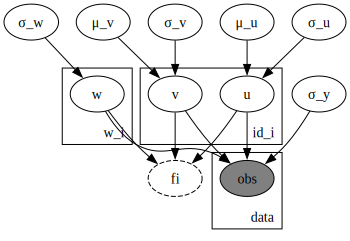

In [16]:
# render the enhanced model
x_data = features.values
render_model(enhanced_model, model_args=(id_data, x_data, days_data, integrity_data), render_params=True)

In [17]:
# run HMC on the enhanced model
x_data = features.values
nuts_enh = NUTS(enhanced_model)
mcmc_enh = MCMC(nuts_enh, num_warmup=2000, num_samples=2000, num_chains=4)
mcmc_enh.run(random.PRNGKey(0), id=id_data, x_data=x_data, days=days_data, integrity=integrity_data)
mcmc_enh.print_summary()

Compiling.. :   0%|          | 0/4000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/4000 [00:01<?, ?it/s]


Running chain 0:  25%|██▌       | 1000/4000 [00:07<00:11, 269.73it/s]


Running chain 0:  35%|███▌      | 1400/4000 [00:08<00:07, 370.87it/s]


Running chain 0:  40%|████      | 1600/4000 [00:08<00:05, 418.19it/s]


Running chain 0:  45%|████▌     | 1800/4000 [00:08<00:04, 463.55it/s]


Running chain 0:  50%|█████     | 2000/4000 [00:09<00:04, 476.63it/s]


Running chain 0:  55%|█████▌    | 2200/4000 [00:09<00:03, 454.56it/s]


Running chain 0:  60%|██████    | 2400/4000 [00:10<00:03, 442.09it/s]


Running chain 0:  65%|██████▌   | 2600/4000 [00:10<00:03, 433.36it/s]


Running chain 0:  70%|███████   | 2800/4000 [00:11<00:02, 427.12it/s]




Running chain 0:  75%|███████▌  | 3000/4000 [00:11<00:02, 423.43it/s]


Running chain 0:  80%|████████  | 3200/4000 [00:12<00:01, 421.21it/s]


Running chain 0:  85%|████████▌ | 3400/4000 [00:12<00:01, 419.27it/s]


Running chain 


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      u[0]     94.21      2.16     94.20     90.74     97.82  14222.37      1.00
      u[1]     91.73      3.68     91.74     85.56     97.62  11779.36      1.00
      u[2]     98.41      2.11     98.39     94.90    101.83  13466.70      1.00
      u[3]     89.37      2.05     89.34     86.05     92.72  15524.12      1.00
      u[4]     89.63      3.23     89.62     84.51     95.17  15365.45      1.00
      u[5]     88.17      3.48     88.14     82.51     93.89  14802.89      1.00
      u[6]     91.00      2.89     90.97     86.06     95.56  11519.67      1.00
      u[7]     85.07      3.68     85.13     79.07     91.11  10455.44      1.00
      u[8]     90.10      2.81     90.05     85.57     94.77  10755.67      1.00
      u[9]     85.26      3.21     85.26     79.75     90.33   9832.48      1.00
     u[10]     86.61      2.66     86.58     82.24     90.96   9746.54      1.00
     u[11]     89.50      2

array([[<Axes: title={'center': 'μ_u'}>, <Axes: title={'center': 'μ_u'}>],
       [<Axes: title={'center': 'μ_v'}>, <Axes: title={'center': 'μ_v'}>],
       [<Axes: title={'center': 'σ_u'}>, <Axes: title={'center': 'σ_u'}>],
       [<Axes: title={'center': 'σ_v'}>, <Axes: title={'center': 'σ_v'}>],
       [<Axes: title={'center': 'σ_y'}>, <Axes: title={'center': 'σ_y'}>],
       [<Axes: title={'center': 'σ_w'}>, <Axes: title={'center': 'σ_w'}>],
       [<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>],
       [<Axes: title={'center': 'u'}>, <Axes: title={'center': 'u'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

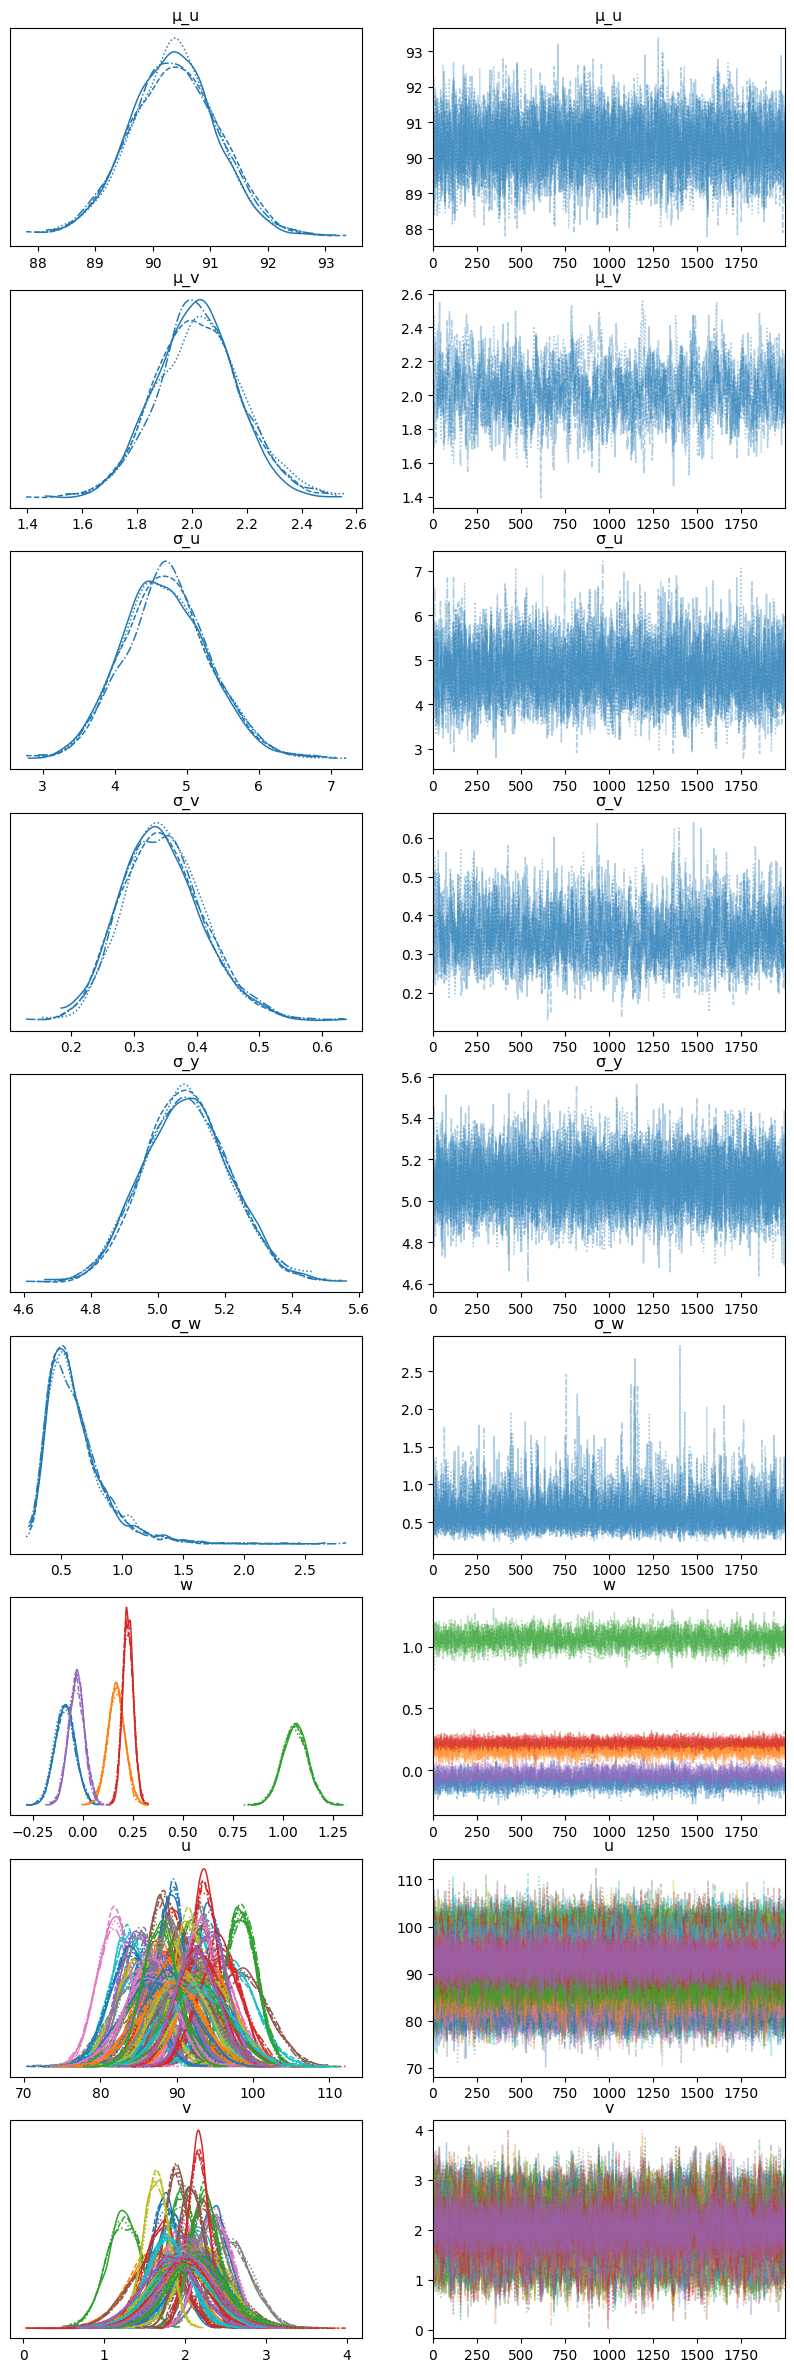

In [18]:
# plotting the results
data = az.from_numpyro(mcmc_enh)
az.plot_trace(data, compact=True, var_names=["μ_u", "μ_v", "σ_u", "σ_v", "σ_y", "σ_w", "w", "u", "v"],  figsize=(10, 30))

In [19]:
# extract posterior samples
samples_enh = mcmc_enh.get_samples()

# predictive functions for enhanced model
def predict_enhanced_overall(id, mcmc_samples, data, t):
    ui = mcmc_samples['u'][:, id][:, None]
    vi = mcmc_samples['v'][:, id][:, None]
    w = mcmc_samples['w']
    x = data[id]
    wx = jnp.dot(w, x)[:, None]
    Y = ui * jnp.exp(- (vi + wx) * t / 100)
    f_mean = jnp.mean(Y, axis=0)
    noise_var = jnp.mean(mcmc_samples['σ_y']) ** 2
    f_var = jnp.var(Y, axis=0) + noise_var
    f_std = jnp.sqrt(f_var)
    return np.asarray(f_mean), np.asarray(f_std)

def predict_enhanced_function(id, mcmc_samples, data, t):
    ui = mcmc_samples['u'][:, id][:, None]
    vi = mcmc_samples['v'][:, id][:, None]
    w = mcmc_samples['w']
    x = data[id]
    wx = jnp.dot(w, x)[:, None]
    Y = ui * jnp.exp(- (vi + wx) * t / 100)
    f_mean = jnp.mean(Y, axis=0)
    f_var = jnp.var(Y, axis=0)
    f_std = jnp.sqrt(f_var)
    return np.asarray(f_mean), np.asarray(f_std)

In [71]:
# plot enhanced predictions
def plot_predictions_enhanced(component):
    mean_f, std_f = predict_enhanced_function(component, samples_enh, x_data, t_vals)
    mean_o, std_o = predict_enhanced_overall(component, samples_enh, x_data, t_vals)

    actual = measurements[measurements['index'] == component]
    x = actual['day']
    y = actual['integrity']

    _, ax = plt.subplots(figsize=(8, 5))
    ax.set_title(f"Enhanced Model Prediction Graph - Component {component}")
    ax.scatter(x, y, label="Observed Data")
    ax.plot(t_vals, mean_f, color="firebrick", label="Posterior Mean")
    ax.fill_between(t_vals, mean_f - 1.96 * std_f, mean_f + 1.96 * std_f, color = "Skyblue", alpha=0.5, label="Function Error Bar")
    ax.fill_between(t_vals, mean_o - 1.96 * std_o, mean_o + 1.96 * std_o, color = "Goldenrod", alpha=0.3, label="Function+Noise Error Bar")
    ax.set_xlabel("Day")
    ax.set_ylabel("Integrity (%)")
    ax.set_ylim(0, 100)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

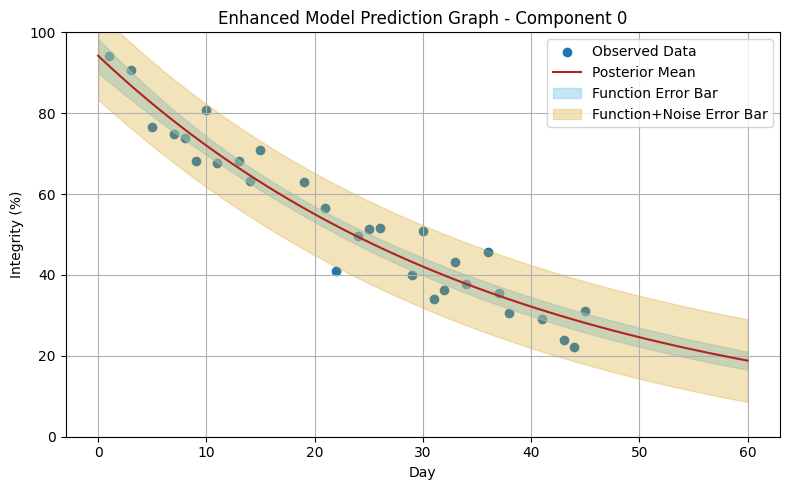

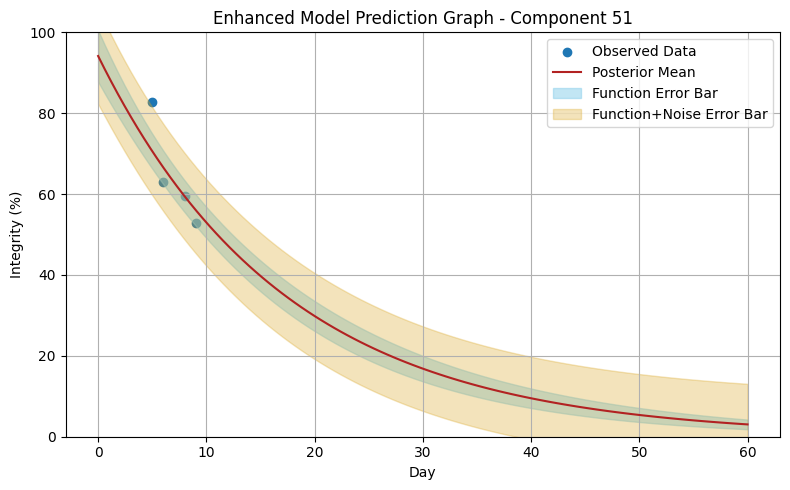

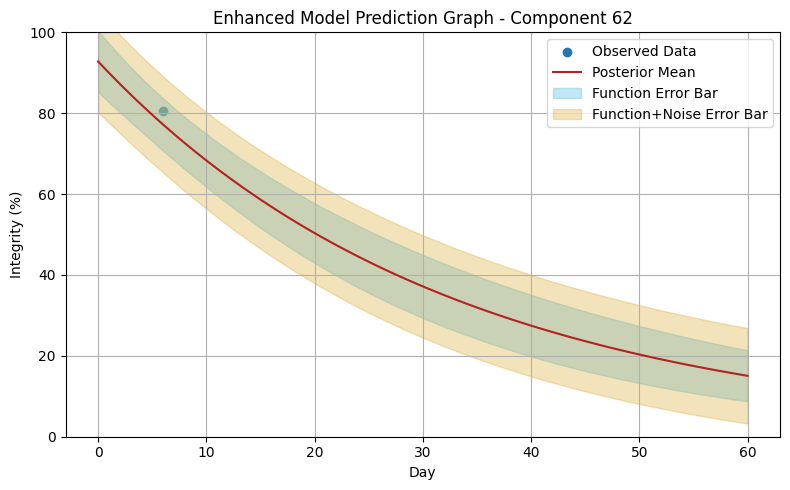

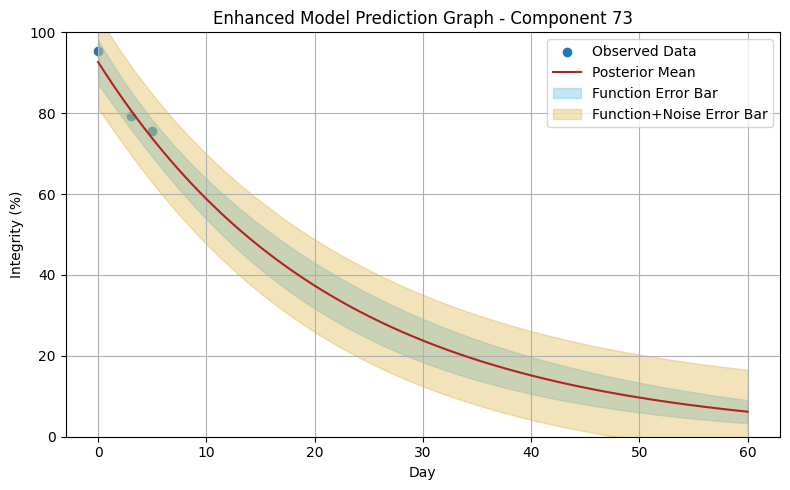

In [72]:
for component in [0, 51, 62, 73]:
    plot_predictions_enhanced(component)

## Blind Test Predictions

Predicting the integrity <= 30 at day = 30 for components 50–74

In [42]:
# blind test predictions using enhanced_overall
test_ids = np.arange(50, 75)
t_test = 30
results = []

for id in test_ids:
    mean_f, std_f = predict_enhanced_overall(id, samples_enh, x_data, t_test)
    
    # calc the probability that the predicted integrity is <= 30
    prob = norm.cdf(30, loc=mean_f.item(), scale=std_f.item())
    
    results.append({"ID": f"K#{id:04d}", "index": id, "probability": prob})

# convert results to df and save to csv
res = pd.DataFrame(results)
res.to_csv("predictions.csv", index=False)

In [43]:
# print out the first 5 res rows
res.head()

,ID,index,probability
0,K#0050,50,0.267128
1,K#0051,51,0.993183
2,K#0052,52,1.000000
3,K#0053,53,0.457354
4,K#0054,54,0.042070


## Black Box Model

Training a “black‐box‐style” function model that maps some input features from t ∈[0,10] to output a prediction of the integrity value at t = 30. We are using a Linear Regression model to predict the component integrity.

In [53]:
# extract and engineer features for the linear regression model
def feature_engineering(measurements, features):
    
    x_rows = []
    ids = []
    y = []

    for m in measurements['index'].unique():
        component_measurements = measurements[measurements['index'] == m]
        subset = component_measurements[component_measurements['day'] <= 10]

        if subset.empty:
            continue

        avg_integrity = subset['integrity'].mean()
        log_avg_integrity = np.log1p(avg_integrity)
        avg_std = subset['integrity'].std() if len(subset) > 1 else 0
        avg_gradient = np.polyfit(subset['day'], subset['integrity'], 1)[0] if len(subset) > 1 else 0

        x_feats = features.loc[m].values

        target_subset = component_measurements[(component_measurements['day'] == 30)]
        
        if not target_subset.empty:
            row = list(x_feats) + [avg_integrity, log_avg_integrity, avg_std, avg_gradient]
            x_rows.append(row)
            y.append(target_subset['integrity'].values[0])
            ids.append(m)

    # create the dataframe
    x_df = pd.DataFrame(x_rows, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'avg_integrity', 'log_avg_integrity', 'avg_std', "avg_gradient"])
    y = np.array(y)
    ids = np.array(ids)

    return x_df, y, ids

In [54]:
# print out the features
x_df, y, ids = feature_engineering(measurements, features)
print(x_df.shape)
x_df.head()

(18, 9)


,x1,x2,x3,x4,x5,avg_integrity,log_avg_integrity,avg_std,avg_gradient
0,1.897,1.111,0.585,1.436,3.684,79.903143,4.393253,9.390419,-2.298485
1,0.448,2.945,0.749,1.087,0.428,79.850889,4.392607,9.088078,-2.912333
2,5.816,1.220,0.682,12.838,0.723,68.885636,4.246860,14.796895,-3.968218
3,0.574,1.037,0.286,1.919,0.982,65.725000,4.200580,4.582568,-0.330600
4,0.708,0.700,0.798,0.207,0.631,76.252111,4.347074,7.163223,-2.103310


In [57]:
# train test split
x_train_df, x_test_df, y_train, y_test, train_ids, test_ids = train_test_split(x_df, y, ids, test_size=0.3)

# train the linear regression model
blackbox = LinearRegression()
blackbox.fit(x_train_df, y_train)

# blackbox predictions for the test set
blackbox_preds = blackbox.predict(x_test_df)

# bayesian predictions for the test set
bayes_preds = []
bayes_errors = []

posterior = mcmc_enh.get_samples()

for id in test_ids:
    mean_f, std_f = predict_enhanced_overall(id, posterior, x_data, t_test)
    bayes_preds.append(mean_f.item())
    bayes_errors.append(std_f.item())

bayes_preds = np.array(bayes_preds)
bayes_errors = np.array(bayes_errors)

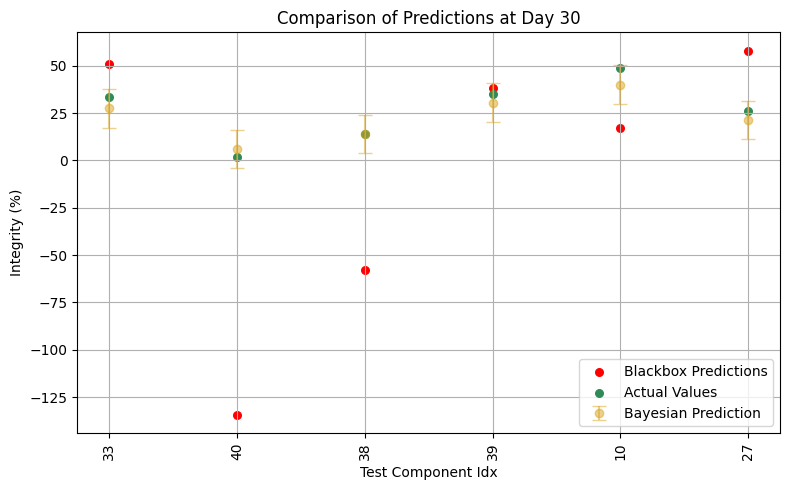

In [68]:
# plotting the results
plt.figure(figsize=(8, 5))

x_vals = np.arange(len(test_ids))

# plot bayesian predictions
plt.errorbar(x_vals, bayes_preds, yerr=1.96 * bayes_errors, fmt='o', capsize=5, color='goldenrod', alpha=0.5, label='Bayesian Prediction')

# scatter plot for Blackbox predictions
plt.scatter(x_vals, blackbox_preds, color='red', s=30, label='Blackbox Predictions')

# scatter plot for actual values
plt.scatter(x_vals, y_test, color='seagreen', s=30, label='Actual Values')

plt.xlabel('Test Component Idx')
plt.ylabel('Integrity (%)')
plt.title('Comparison of Predictions at Day 30')
plt.xticks(x_vals, test_ids, rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()